# Helper Functions for Raman Peak Analysis
Reusable utilities for **peak fitting**, **baseline subtraction**, **smoothing**, and **λ ↔ Raman‑shift** conversion.

This notebook is designed as a small *toolbox* that other notebooks (calibration, spectra analysis, depolarization ratio, etc.) can import or copy from.

**Quick usage**: run the function cells once, then call the functions from later cells (or `%run helper_peakfit_functions.ipynb` in another notebook).

> Tip: Keep this file in `02_Notebooks/` and import functions by executing the relevant cells.




## Contents
1. [Unit conversions: λ ↔ Raman shift](#conversions)  
2. [Smoothing](#smoothing)  
3. [Baseline subtraction (Asymmetric Least Squares)](#baseline)  
4. [Peak models and fitting](#peaks)  
5. [Peak finding & integration](#find_integrate)  
6. [Mini demo on synthetic data](#demo)  


## 1) Unit conversions: λ ↔ Raman shift <a id="conversions"></a>

- **Raman shift (cm⁻¹)** from excitation wavelength **λ₀** (nm) and scattered wavelength **λ** (nm):  
  $ \Delta\tilde{\nu} = 10^7 \left( \frac{1}{\lambda_0} - \frac{1}{\lambda} \right) $

- **Inverse conversion (given shift and λ₀):**  
  $ \lambda = \frac{1}{\frac{1}{\lambda_0} - \frac{\Delta\tilde{\nu}}{10^7}} $

All wavelengths in **nm**, shifts in **cm⁻¹**.



In [1]:

import numpy as np

def raman_shift_from_wavelength_nm(lambda_exc_nm: float, lambda_scat_nm):
    """
    Compute Raman shift (in cm^-1) from excitation wavelength (nm)
    and scattered wavelength(s) (nm). Accepts float or array for lambda_scat_nm.
    """
    lam0 = float(lambda_exc_nm)
    lam = np.asarray(lambda_scat_nm, dtype=float)
    return 1e7*(1.0/lam0 - 1.0/lam)

def wavelength_nm_from_raman_shift(lambda_exc_nm: float, shift_cm):
    """
    Compute scattered wavelength (nm) from excitation wavelength (nm)
    and Raman shift (cm^-1). Accepts float or array for shift_cm.
    """
    lam0 = float(lambda_exc_nm)
    shift = np.asarray(shift_cm, dtype=float)
    inv_lam = (1.0/lam0) - (shift/1e7)
    return 1.0/inv_lam



## 2) Smoothing <a id='smoothing'></a>

Savitzky–Golay smoothing via `scipy.signal.savgol_filter` (polynomial smoothing that preserves peak shapes reasonably well).


In [2]:

import numpy as np
from scipy.signal import savgol_filter

def smooth_savgol(y, window_length: int = 11, polyorder: int = 3):
    """
    Smooth a 1D signal using Savitzky–Golay filter.
    window_length must be odd and >= polyorder+2.
    """
    if window_length % 2 == 0:
        window_length += 1  # ensure odd length
    return savgol_filter(np.asarray(y, dtype=float), window_length, polyorder)



## 3) Baseline subtraction (Asymmetric Least Squares) <a id='baseline'></a>

Robust baseline estimation using the Eilers & Boelens (2005) Asymmetric Least Squares method.
Good defaults for Raman: `lam ~ 1e5–1e7`, `p ~ 0.001–0.05`, `niter ~ 10`.
Return value is the estimated baseline (to subtract from the signal).


In [3]:

import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam: float = 1e6, p: float = 0.01, niter: int = 10):
    """
    Asymmetric Least Squares baseline.
    y: 1D array
    lam: smoothness parameter (higher -> smoother baseline)
    p: asymmetry (0<p<1). Smaller p puts more weight on negative residuals.
    niter: number of reweighting iterations
    Returns: baseline array of same shape as y
    """
    y = np.asarray(y, dtype=float)
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.T)
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z



## 4) Peak models & fitting <a id='peaks'></a>

Built-in models: **Gaussian**, **Lorentzian**, **Voigt**.  
Use `fit_peaks_sum()` to fit a sum of N identical-type peaks given initial guesses.


In [4]:

import numpy as np
from typing import List, Tuple, Dict, Callable
from scipy.optimize import curve_fit
from scipy.special import wofz

# --- Line shapes ---
def gaussian(x, amp, cen, sigma):
    return amp * np.exp(-0.5*((x-cen)/sigma)**2)

def lorentzian(x, amp, cen, gamma):
    return amp * (gamma**2 / ((x-cen)**2 + gamma**2))

def voigt(x, amp, cen, sigma, gamma):
    # real part of Faddeeva function
    z = ((x-cen) + 1j*gamma) / (sigma*np.sqrt(2))
    return amp * np.real(wofz(z)) / (sigma*np.sqrt(2*np.pi))

# --- Sum-of-peaks builders ---
def _sum_model_factory(kind: str, n_peaks: int) -> Callable:
    kind = kind.lower()
    if kind == "gaussian":
        npar = 3
        def model(x, *params):
            y = np.zeros_like(x, dtype=float)
            for i in range(n_peaks):
                amp, cen, sig = params[3*i:3*i+3]
                y += gaussian(x, amp, cen, sig)
            return y
    elif kind == "lorentzian":
        npar = 3
        def model(x, *params):
            y = np.zeros_like(x, dtype=float)
            for i in range(n_peaks):
                amp, cen, gam = params[3*i:3*i+3]
                y += lorentzian(x, amp, cen, gam)
            return y
    elif kind == "voigt":
        npar = 4
        def model(x, *params):
            y = np.zeros_like(x, dtype=float)
            for i in range(n_peaks):
                amp, cen, sig, gam = params[4*i:4*i+4]
                y += voigt(x, amp, cen, sig, gam)
            return y
    else:
        raise ValueError("kind must be 'gaussian', 'lorentzian', or 'voigt'")
    model.npar = npar
    return model

def fit_peaks_sum(x, y, kind: str, p0: List[float], bounds=(-np.inf, np.inf)):
    """
    Fit a sum of N peaks of the same kind.
    kind: 'gaussian' | 'lorentzian' | 'voigt'
    p0: flat list of initial parameters [amp1, cen1, w1, amp2, cen2, w2, ...]
        (for Voigt each peak uses [amp, cen, sigma, gamma])
    bounds: (lower, upper) for curve_fit
    Returns: popt, pcov, model_function
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n_params_per_peak = {"gaussian":3, "lorentzian":3, "voigt":4}[kind.lower()]
    assert len(p0) % n_params_per_peak == 0, "p0 length must be multiple of params/peak"
    n_peaks = len(p0)//n_params_per_peak
    model = _sum_model_factory(kind, n_peaks)
    popt, pcov = curve_fit(model, x, y, p0=p0, bounds=bounds, maxfev=10000)
    return popt, pcov, model



## 5) Peak finding & integration <a id='find_integrate'></a>

- `find_candidate_peaks(...)` wraps `scipy.signal.find_peaks` with handy defaults.
- `integrate_window(...)` integrates area in a specified x-window using trapezoidal rule.


In [5]:

import numpy as np
from scipy.signal import find_peaks

def find_candidate_peaks(y, height=None, distance=None, prominence=None, width=None):
    """
    Wrapper around scipy.signal.find_peaks.
    Returns indices and the raw properties dict from scipy.
    """
    y = np.asarray(y, dtype=float)
    idx, props = find_peaks(y, height=height, distance=distance, prominence=prominence, width=width)
    return idx, props

def integrate_window(x, y, x_min, x_max):
    """
    Integrate y over [x_min, x_max] using trapezoidal rule.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = (x >= x_min) & (x <= x_max)
    if mask.sum() < 2:
        return 0.0
    return np.trapz(y[mask], x[mask])



## 6) Mini demo on synthetic data <a id='demo'></a>

This is a *tiny tutorial-style* example (not a solution!).
- We generate a synthetic spectrum (2 peaks + sloped baseline + noise).
- We smooth, estimate & subtract baseline, auto-find peaks, then fit Gaussians.


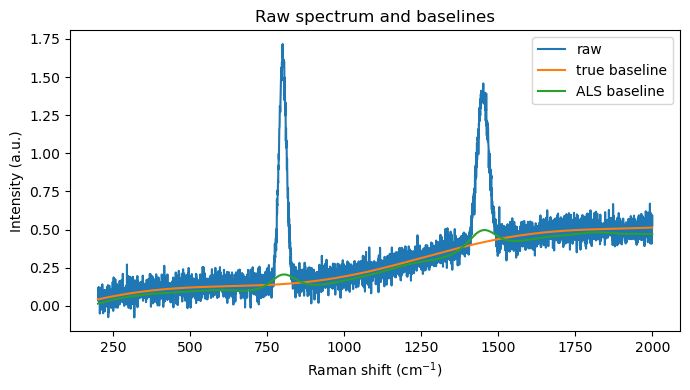

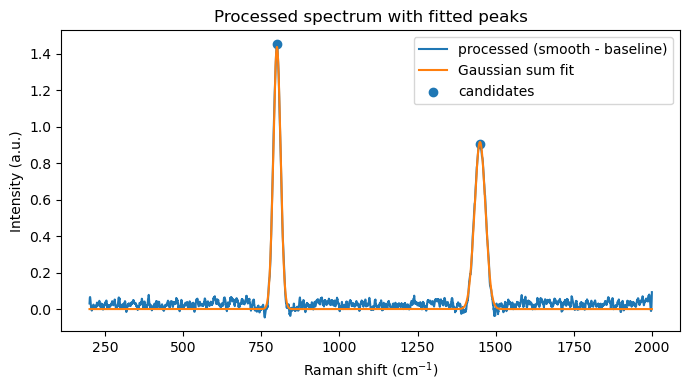

[{'amp': 1.4372164625055286,
  'center': 799.8867073444768,
  'sigma': 11.595609577351073},
 {'amp': 0.916091201593495,
  'center': 1449.832219679232,
  'sigma': 17.360135173722444}]

In [6]:

import numpy as np
import matplotlib.pyplot as plt

# --- Synthetic spectrum (Raman shift axis) ---
np.random.seed(42)
x = np.linspace(200, 2000, 4000)
true = ( 1.5*np.exp(-0.5*((x-800)/12)**2)
       + 1.0*np.exp(-0.5*((x-1450)/18)**2) )
baseline_true = 0.0003*(x-200) + 0.05*np.sin(x/200)
noise = 0.05*np.random.randn(x.size)
y_raw = true + baseline_true + noise

# --- Smooth & baseline ---
y_smooth = smooth_savgol(y_raw, window_length=21, polyorder=3)
base = baseline_als(y_smooth, lam=2e6, p=0.01, niter=10)
y_proc = y_smooth - base

# --- Peak candidates ---
idx, props = find_candidate_peaks(y_proc, prominence=0.1, distance=50)

# --- Fit: 2 Gaussians using initial guesses from peak indices ---
# initial guesses (amp, cen, sigma) for each peak
p0 = []
for i in idx[:2]:
    p0 += [y_proc[i], x[i], 10.0]
popt, pcov, model = fit_peaks_sum(x, y_proc, "gaussian", p0=p0)

# --- Plot raw vs baseline ---
plt.figure(figsize=(7,4))
plt.plot(x, y_raw, label="raw")
plt.plot(x, baseline_true, label="true baseline")
plt.plot(x, base, label="ALS baseline")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.title("Raw spectrum and baselines")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot processed with fit ---
y_fit = model(x, *popt)
plt.figure(figsize=(7,4))
plt.plot(x, y_proc, label="processed (smooth - baseline)")
plt.plot(x, y_fit, label="Gaussian sum fit")
plt.scatter(x[idx], y_proc[idx], label="candidates")
plt.xlabel("Raman shift (cm$^{-1}$)")
plt.ylabel("Intensity (a.u.)")
plt.title("Processed spectrum with fitted peaks")
plt.legend()
plt.tight_layout()
plt.show()

# --- Report fitted parameters ---
npar = 3
peaks = []
for k in range(len(popt)//npar):
    amp, cen, sig = popt[npar*k:npar*k+3]
    peaks.append(dict(amp=amp, center=cen, sigma=sig))
peaks
